100%|██████████| 9.91M/9.91M [00:00<00:00, 18.6MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 490kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.61MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 10.9MB/s]
Epoch 10/10: 100%|██████████| 469/469 [00:11<00:00, 39.32it/s, loss=nan]


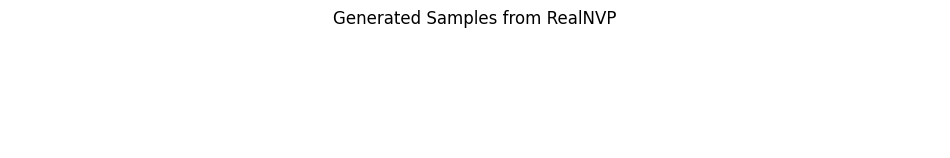

In [1]:
# Flow-Based Model: RealNVP for MNIST in PyTorch

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Data loading
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x + 1e-6),  # avoid log(0)
    transforms.Lambda(lambda x: x.view(-1))
])
dataset = datasets.MNIST(root="./data", train=True, transform=transform, download=True)
dataloader = DataLoader(dataset, batch_size=128, shuffle=True)

# Affine coupling layer
class CouplingLayer(nn.Module):
    def __init__(self, dim, mask):
        super().__init__()
        self.dim = dim
        self.mask = mask
        self.scale_net = nn.Sequential(nn.Linear(dim, 256), nn.ReLU(), nn.Linear(256, dim))
        self.translate_net = nn.Sequential(nn.Linear(dim, 256), nn.ReLU(), nn.Linear(256, dim))

    def forward(self, x):
        x_masked = x * self.mask
        s = self.scale_net(x_masked) * (1 - self.mask)
        t = self.translate_net(x_masked) * (1 - self.mask)
        y = x_masked + (1 - self.mask) * (x * torch.exp(s) + t)
        log_det = s.sum(dim=1)
        return y, log_det

    def inverse(self, y):
        y_masked = y * self.mask
        s = self.scale_net(y_masked) * (1 - self.mask)
        t = self.translate_net(y_masked) * (1 - self.mask)
        x = y_masked + (1 - self.mask) * ((y - t) * torch.exp(-s))
        return x

# RealNVP Model
class RealNVP(nn.Module):
    def __init__(self, dim, num_coupling_layers=6):
        super().__init__()
        self.dim = dim
        self.layers = nn.ModuleList()
        for i in range(num_coupling_layers):
            mask = self._create_mask(i % 2)
            self.layers.append(CouplingLayer(dim, mask))

    def _create_mask(self, parity):
        mask = torch.zeros(self.dim)
        mask[::2] = 1 if parity == 0 else 0
        mask[1::2] = 0 if parity == 0 else 1
        return mask.to(device)

    def forward(self, x):
        log_det_sum = 0
        for layer in self.layers:
            x, log_det = layer(x)
            log_det_sum += log_det
        return x, log_det_sum

    def inverse(self, z):
        for layer in reversed(self.layers):
            z = layer.inverse(z)
        return z

# Initialize model
model = RealNVP(dim=28*28).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# Training loop
for epoch in range(10):
    pbar = tqdm(dataloader, desc=f"Epoch {epoch+1}/10")
    for x, _ in pbar:
        x = x.to(device)
        z, log_det = model(x)
        log_prob = -0.5 * (z ** 2).sum(dim=1) - 0.5 * model.dim * np.log(2 * np.pi)
        loss = -(log_prob + log_det).mean()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        pbar.set_postfix(loss=loss.item())

# Sampling from model
def sample(model, n_samples=8):
    z = torch.randn(n_samples, model.dim).to(device)
    x = model.inverse(z).view(-1, 1, 28, 28)
    x = x.detach().cpu().numpy()
    x = np.clip(x, 0, 1)
    return x

# Visualization
def show_images(images, title=""):
    grid = np.concatenate([img.squeeze() for img in images], axis=1)
    plt.figure(figsize=(12, 2))
    plt.imshow(grid, cmap='gray')
    plt.axis('off')
    plt.title(title)
    plt.show()

samples = sample(model, 8)
show_images(samples, title="Generated Samples from RealNVP")
